<a href="https://colab.research.google.com/github/dksifoua/Question-Answering/blob/master/1%20-%20DrQA%2C%20Document%20reader%20Question%20Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Wed Oct  5 13:25:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.01    Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:08:00.0  On |                  N/A |
|  0%   39C    P8    16W / 170W |    675MiB / 12288MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [3]:
# !pip install tqdm --upgrade >> /dev/null 2>&1
# !pip install spacy --upgrade >> /dev/null 2>&1
# !python -m spacy download en_core_web_lg >> /dev/null 2>&1

In [5]:
import os
import re
import json
import time
import tqdm
import spacy
import pickle
import random
import string
import itertools
import functools
import collections
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
from spacy.tokens import Doc
from typing import Any, Dict, List, NamedTuple, Union, Tuple
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

In [6]:
current_working_directory = os.getcwd()
print(f"Current working directory: {current_working_directory}")

if current_working_directory.split('/')[-1] == "notebooks":
    os.chdir("../")

print(f"New current working directory: {os.getcwd()}")

Current working directory: /mnt/c/Users/dimit/PycharmProjects/Question-Answering/notebooks
New current working directory: /mnt/c/Users/dimit/PycharmProjects/Question-Answering


In [7]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # https://pytorch.org/docs/stable/notes/randomness.html
    # torch.use_deterministic_algorithms(True)
    # torch.backends.cudnn.benchmark = False

In [8]:
SEED = 546
seed_everything(seed=SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


## Prepare data

***Download data***

In [9]:
# !rm -rf ./data
# !mkdir ./data
#
# !wget --no-check-certificate \
#     https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json \
#     -O ./data/train-v1.1.json
#
# !wget --no-check-certificate \
#     https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json \
#     -O ./data/dev-v1.1.json

***Load JSON data***

In [10]:
@dataclasses.dataclass
class _UnpackingDataClassMixin:

    def __iter__(self):
        return iter(dataclasses.astuple(self))


@dataclasses.dataclass
class Target(_UnpackingDataClassMixin):
    start_index: int
    end_index: int


@dataclasses.dataclass
class RawDatasetItem(_UnpackingDataClassMixin):
    id_: str
    context: Doc
    question: Doc
    answer: Doc
    answer_start_index: int
    target: Target = None

In [11]:
class IO:

    @staticmethod
    def load_from_json(path: str) -> Dict:
        try:
            with open(path, mode='r', encoding="utf-8") as json_file:
                return json.load(json_file)
        except IOError:
            raise IOError

In [12]:
%%time
train_raw_data = IO.load_from_json(path="./data/train-v1.1.json")
valid_raw_data = IO.load_from_json(path="./data/dev-v1.1.json")
print(f"Length of raw train data: {len(train_raw_data['data']):,}")
print(f"Length of raw valid data: {len(valid_raw_data['data']):,}")

Length of raw train data: 442
Length of raw valid data: 48
CPU times: user 365 ms, sys: 88.8 ms, total: 454 ms
Wall time: 663 ms


***Parse JSON data***

In [13]:
def parse_squad_v1_data(data: Dict, spacy_nlp: spacy.language.Language) -> List[RawDatasetItem]:
    qas = []
    disabled_components = ["parser", "lemmatizer", "tagger", "ner"]
    for paragraphs in tqdm.tqdm(data["data"]):
        for paragraph in paragraphs["paragraphs"]:
            context = spacy_nlp(paragraph["context"], disable=disabled_components[:1])
            for qa in paragraph["qas"]:
                id_ = qa["id"]
                question = spacy_nlp(qa["question"], disable=disabled_components)
                for answer in qa["answers"]:
                    qas.append(RawDatasetItem(id_=id_, context=context, question=question,
                                              answer=spacy_nlp(answer["text"], disable=disabled_components),
                                              answer_start_index=answer["answer_start"]))
    return qas

In [14]:
%%time
language = spacy.load(name="en_core_web_lg")

train_qas = parse_squad_v1_data(data=train_raw_data, spacy_nlp=language)
valid_qas = parse_squad_v1_data(data=valid_raw_data, spacy_nlp=language)
print(f"Length of train qa pairs: {len(train_qas):,}")
print(f"Length of valid qa pairs: {len(valid_qas):,}")
print(f"Train example: {train_qas[random.randint(a=0, b=len(train_qas) - 1)]}")

100%|██████████| 48/48 [01:22<00:00,  1.71s/it]

Length of train qa pairs: 87,599
Length of valid qa pairs: 34,726
Train example: RawDatasetItem(id_='56cc100b6d243a140015ee8d', context=During the summers at Nohant, particularly in the years 1839–43, Chopin found quiet, productive days during which he composed many works, including his Polonaise in A-flat major, Op. 53. Among the visitors to Nohant were Delacroix and the mezzo-soprano Pauline Viardot, whom Chopin had advised on piano technique and composition. Delacroix gives an account of staying at Nohant in a letter of 7 June 1842:, question=On what date did Delacroix write a letter based on his visit at Nohant?, answer=7 June 1842, answer_start_index=393, target=None)
CPU times: user 8min 48s, sys: 3.14 s, total: 8min 51s
Wall time: 8min 51s


In [15]:
def test_answer_start_indexes(qas: List[RawDatasetItem]) -> None:
    for qa in tqdm.tqdm(qas):  # type: RawDatasetItem
        assert qa.answer.text == qa.context.text[qa.answer_start_index:qa.answer_start_index + len(qa.answer.text)]

In [16]:
test_answer_start_indexes(qas=train_qas)
test_answer_start_indexes(qas=valid_qas)

100%|██████████| 34726/34726 [00:01<00:00, 22675.68it/s]


***Add targets***

In [17]:
def add_targets_to_squad_v1_data(qas: List[RawDatasetItem]) -> None:
    for qa in tqdm.tqdm(qas):  # type: RawDatasetItem
        for i in range(len(qa.context)):
            if qa.context[i].idx == qa.answer_start_index:
                answer = qa.context[i:i + len(qa.answer)]
                qa.target = Target(start_index=answer[0].i, end_index=answer[-1].i)

In [18]:
%%time
add_targets_to_squad_v1_data(qas=train_qas)
add_targets_to_squad_v1_data(qas=valid_qas)

100%|██████████| 34726/34726 [00:00<00:00, 38561.76it/s]

CPU times: user 3.11 s, sys: 10.2 ms, total: 3.12 s
Wall time: 3.1 s


In [19]:
def is_bad_item(qa: RawDatasetItem) -> bool:
    """Return True if either the target is None or target indexes don't match the answer. Return False otherwise"""
    if qa.target is None:
        return False
    return qa.answer.text == qa.context[qa.target.start_index:qa.target.end_index + 1].text

In [20]:
%%time
train_qas = [*filter(is_bad_item, train_qas)]
valid_qas = [*filter(is_bad_item, valid_qas)]
print(f"Length of train qa pairs after filtering out bad qa pairs: {len(train_qas):,}")
print(f"Length of valid qa pairs after filtering out bad qa pairs: {len(valid_qas):,}")

Length of train qa pairs after filtering out bad qa pairs: 86,676
Length of valid qa pairs after filtering out bad qa pairs: 34,364
CPU times: user 699 ms, sys: 66 µs, total: 699 ms
Wall time: 698 ms


In [21]:
def test_targets(qas: List[RawDatasetItem]) -> None:
    for qa in qas:
        assert qa.answer.text == qa.context[qa.target.start_index:qa.target.end_index + 1].text

In [22]:
%%time
test_targets(qas=train_qas)
test_targets(qas=valid_qas)

CPU times: user 674 ms, sys: 0 ns, total: 674 ms
Wall time: 672 ms


***Add features***

In [23]:
@dataclasses.dataclass
class TokenFeature(_UnpackingDataClassMixin):
    exact_match: List[bool]
    part_of_speech: List[str]
    named_entity_type: List[str]
    normalized_term_frequency: List[float]


@dataclasses.dataclass
class DrQARawDatasetItem(RawDatasetItem):
    token_feature: TokenFeature = None


def add_extra_features_squad_v1(qas: List[RawDatasetItem]) -> List[DrQARawDatasetItem]:
    """Add extra features: Exact Match, Part-of-Speech, Name Entity Recognition & Normalized Term Frequency"""
    qa_token_features = []
    for qa in tqdm.tqdm(qas):  # type: RawDatasetItem
        question = [token.text.lower() for token in qa.question]
        count_context_tokens = collections.Counter(map(lambda token: token.text.lower(), qa.context))

        frequency_context_tokens: Dict[int, int] = {}
        for index, token in enumerate(qa.context):  # type: int, Token
            frequency_context_tokens[index] = count_context_tokens[token.text.lower()]
        norm_frequency_context_tokens = sum(frequency_context_tokens.values())

        token_feature = TokenFeature(
            exact_match=[qa.context[index].text.lower() in question for index in range(len(qa.context))],
            part_of_speech=[qa.context[index].tag_ for index in range(len(qa.context))],
            named_entity_type=[qa.context[index].ent_type_ for index in range(len(qa.context))],
            normalized_term_frequency=[
                frequency_context_tokens[index] / norm_frequency_context_tokens for index in range(len(qa.context))
            ]
        )

        qa_token_features.append(
            DrQARawDatasetItem(
                id_=qa.id_,
                context=qa.context,
                question=qa.question,
                answer=qa.answer,
                answer_start_index=qa.answer_start_index,
                target=qa.target,
                token_feature=token_feature
            )
        )

    return qa_token_features

In [24]:
%%time
train_qas = add_extra_features_squad_v1(qas=train_qas)
valid_qas = add_extra_features_squad_v1(qas=valid_qas)

100%|██████████| 34364/34364 [00:11<00:00, 2895.14it/s]

CPU times: user 36.1 s, sys: 1.45 s, total: 37.6 s
Wall time: 37.4 s


***Build vocabularies***

In [25]:
class Vocabulary:

    def __init__(self, padding_token: str, unknown_token: str):
        self.padding_token = padding_token
        self.unknown_token = unknown_token

        self.vocabulary: List[str] = []
        self.word2count: Dict[str, int] = {}
        self.word2index: Dict[str, int] = {}
        self.index2word: Dict[int, str] = {}

    def build(self, data: List[Union[Doc, str]], min_word_frequency: int) -> None:
        words = []

        type_ = type(data[0])
        if type_ == Doc:
            for item in data:  # Doc
                words += [word.text.lower() for word in item]
        elif type_ == str:
            words += data
        else:
            raise TypeError(f"The type {type_} is not supported!")

        self.word2count = collections.Counter(words)
        self.vocabulary = [self.padding_token] + sorted(filter(
            lambda word: self.word2count[word] >= min_word_frequency,
            self.word2count
        )) + [self.unknown_token]  # Ensure that pad token gets index 0 and unknown token gets the las index
        self.word2index = {word: index for index, word in enumerate(self.vocabulary)}
        self.index2word = {index: word for index, word in enumerate(self.vocabulary)}

    def __len__(self) -> int:
        return len(self.vocabulary)

    def stoi(self, word: str) -> int:
        """
        Return the index of the word in the vocabulary.
        Return the index of the unknown token if that word doesn't exist in the vocabulary.
        """
        return self.word2index.get(word, self.word2index[self.unknown_token])

    def itos(self, index: int) -> str:
        """Return the word of the index in the vocabulary."""
        return self.index2word[index]

In [26]:
%%time
PADDING_TOKEN = "<pad>"
UNKNOWN_TOKEN = "<unk>"
MIN_FREQUENCY = 5

ids = [*map(lambda qa: qa.id_, train_qas)] + [*map(lambda qa: qa.id_, valid_qas)]
contexts, questions = zip(*map(lambda qa: (qa.context, qa.question), train_qas))
part_of_speeches = [*itertools.chain.from_iterable(map(lambda qa: qa.token_feature.part_of_speech, train_qas))]
named_entity_types = [*itertools.chain.from_iterable(map(lambda qa: qa.token_feature.named_entity_type, train_qas))]

id_vocabulary = Vocabulary(padding_token=PADDING_TOKEN, unknown_token=UNKNOWN_TOKEN)
text_vocabulary = Vocabulary(padding_token=PADDING_TOKEN, unknown_token=UNKNOWN_TOKEN)
part_of_speech_vocabulary = Vocabulary(padding_token=PADDING_TOKEN, unknown_token=UNKNOWN_TOKEN)
named_entity_types_vocabulary = Vocabulary(padding_token=PADDING_TOKEN, unknown_token=UNKNOWN_TOKEN)

id_vocabulary.build(data=[*set(ids)], min_word_frequency=0)
text_vocabulary.build(data=[*set(contexts + questions)], min_word_frequency=MIN_FREQUENCY)
part_of_speech_vocabulary.build(data=[*set(part_of_speeches)], min_word_frequency=0)
named_entity_types_vocabulary.build(data=[*set(named_entity_types)], min_word_frequency=0)

print(f"Length of id vocabulary: {len(id_vocabulary):,}")
print(f"Length of text vocabulary: {len(text_vocabulary):,}")
print(f"Length of part of speech vocabulary: {len(part_of_speech_vocabulary):,}")
print(f"Length of named entity type vocabulary: {len(named_entity_types_vocabulary):,}")

Length of id vocabulary: 97,200
Length of text vocabulary: 26,884
Length of part of speech vocabulary: 52
Length of named entity type vocabulary: 21
CPU times: user 3.21 s, sys: 481 ms, total: 3.69 s
Wall time: 3.68 s


***Build datasets***

In [27]:
@dataclasses.dataclass
class DrQATensorDatasetItem(_UnpackingDataClassMixin):
    id_: torch.LongTensor
    context: Union[torch.LongTensor, Tuple[torch.LongTensor, torch.LongTensor]]
    question: Union[torch.LongTensor, Tuple[torch.LongTensor, torch.LongTensor]]
    target: torch.LongTensor
    exact_match: torch.LongTensor
    part_of_speech: torch.LongTensor
    named_entity_type: torch.LongTensor
    normalized_term_frequency: torch.FloatTensor


class SquadV1Dataset(Dataset):

    def __init__(self, data: List[DrQARawDatasetItem], id_vocab: Vocabulary, text_vocab: Vocabulary,
                 pos_vocab: Vocabulary, ner_vocab: Vocabulary):
        self.data = data
        self.id_vocab = id_vocab
        self.pos_vocab = pos_vocab
        self.ner_vocab = ner_vocab
        self.text_vocab = text_vocab

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx) -> DrQATensorDatasetItem:
        item: DrQARawDatasetItem = self.data[idx]
        id_ = torch.LongTensor([self.id_vocab.stoi(item.id_)])
        context = torch.LongTensor([*map(lambda token: self.text_vocab.stoi(token.text.lower()), item.context)])
        question = torch.LongTensor([*map(lambda token: self.text_vocab.stoi(token.text.lower()), item.question)])
        target = torch.LongTensor([item.target.start_index, item.target.end_index])
        exact_match = torch.LongTensor(item.token_feature.exact_match)
        part_of_speech = torch.LongTensor(
            [*map(lambda token: self.pos_vocab.stoi(token), item.token_feature.part_of_speech)])
        named_entity_type = torch.LongTensor(
            [*map(lambda token: self.ner_vocab.stoi(token), item.token_feature.named_entity_type)])
        normalized_term_frequency = torch.FloatTensor(item.token_feature.normalized_term_frequency)
        return DrQATensorDatasetItem(
            id_=id_,
            context=context,
            question=question,
            target=target,
            exact_match=exact_match,
            part_of_speech=part_of_speech,
            named_entity_type=named_entity_type,
            normalized_term_frequency=normalized_term_frequency
        )

In [28]:
train_dataset = SquadV1Dataset(
    data=train_qas,
    id_vocab=id_vocabulary,
    text_vocab=text_vocabulary,
    pos_vocab=part_of_speech_vocabulary,
    ner_vocab=named_entity_types_vocabulary
)
valid_dataset = SquadV1Dataset(
    data=valid_qas,
    id_vocab=id_vocabulary,
    text_vocab=text_vocabulary,
    pos_vocab=part_of_speech_vocabulary,
    ner_vocab=named_entity_types_vocabulary
)

train_dataset_item = train_dataset[0]
print(f"id_ shape: {train_dataset_item.id_.shape}")
print(f"context shape: {train_dataset_item.context.shape}")
print(f"question shape: {train_dataset_item.question.shape}")
print(f"target shape: {train_dataset_item.target.shape}")
print(f"exact_match shape: {train_dataset_item.exact_match.shape}")
print(f"part_of_speech shape: {train_dataset_item.part_of_speech.shape}")
print(f"named_entity_type shape: {train_dataset_item.named_entity_type.shape}")
print(f"normalized_term_frequency shape: {train_dataset_item.normalized_term_frequency.shape}")

id_ shape: torch.Size([1])
context shape: torch.Size([142])
question shape: torch.Size([14])
target shape: torch.Size([2])
exact_match shape: torch.Size([142])
part_of_speech shape: torch.Size([142])
named_entity_type shape: torch.Size([142])
normalized_term_frequency shape: torch.Size([142])


***Build data loaders***

In [29]:
DrQATensorDatasetBatch = DrQATensorDatasetItem

def add_padding_and_batch_data(batch: List[DrQATensorDatasetItem], id_vocab: Vocabulary, text_vocab: Vocabulary,
                               pos_vocab: Vocabulary, ner_vocab: Vocabulary, include_lengths: bool,
                               device: torch.device) -> DrQATensorDatasetBatch:
    batch_id = [item.id_ for item in batch]
    batch_context = [item.context for item in batch]
    batch_question = [item.question for item in batch]
    batch_target = [item.target for item in batch]
    batch_exact_match = [item.exact_match for item in batch]
    batch_part_of_speech = [item.part_of_speech for item in batch]
    batch_named_entity_type = [item.named_entity_type for item in batch]
    batch_normalized_term_frequency = [item.normalized_term_frequency for item in batch]

    length_context, length_question = None, None
    if include_lengths:
        length_context = torch.LongTensor([context.size(0) for context in batch_context])  # .to(device)
        length_question = torch.LongTensor([question.size(0) for question in batch_question])  # .to(device)

    batch_padded_id = pad_sequence(batch_id,
                                   batch_first=True,
                                   padding_value=id_vocab.stoi(id_vocab.padding_token)).to(device)
    batch_padded_context = pad_sequence(batch_context,
                                        batch_first=True,
                                        padding_value=text_vocab.stoi(text_vocab.padding_token)).to(device)
    batch_padded_question = pad_sequence(batch_question,
                                         batch_first=True,
                                         padding_value=text_vocab.stoi(text_vocab.padding_token)).to(device)
    batch_padded_target = pad_sequence(batch_target, batch_first=True).to(device)
    batch_padded_exact_match = pad_sequence(batch_exact_match, batch_first=True).to(device)
    batch_padded_part_of_speech = pad_sequence(batch_part_of_speech,
                                               batch_first=True,
                                               padding_value=pos_vocab.stoi(pos_vocab.padding_token)).to(device)
    batch_padded_normalized_term_frequency = pad_sequence(batch_normalized_term_frequency, batch_first=True).to(device)
    batch_padded_named_entity_type = pad_sequence(batch_named_entity_type,
                                                  batch_first=True,
                                                  padding_value=ner_vocab.stoi(ner_vocab.padding_token)).to(device)
    return DrQATensorDatasetBatch(
        id_=batch_padded_id,
        context=(batch_padded_context, length_context),
        question=(batch_padded_question, length_question),
        target=batch_padded_target,
        exact_match=batch_padded_exact_match,
        part_of_speech=batch_padded_part_of_speech,
        named_entity_type=batch_padded_named_entity_type,
        normalized_term_frequency=batch_padded_normalized_term_frequency
    )

In [30]:
BATCH_SIZE = 32

collate_function = functools.partial(add_padding_and_batch_data,
                                     id_vocab=id_vocabulary,
                                     text_vocab=text_vocabulary,
                                     pos_vocab=part_of_speech_vocabulary,
                                     ner_vocab=named_entity_types_vocabulary,
                                     include_lengths=True,
                                     device=DEVICE)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_function)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_function)

for batch in train_dataloader:  # type: DrQATensorDatasetBatch
    print("IDs:", batch.id_.shape)
    print("Context:", batch.context[0].shape, batch.context[1].shape)
    print("Question:", batch.question[0].shape, batch.question[1].shape)
    print("Target:", batch.target.shape)
    print("Exact match:", batch.exact_match.shape)
    print("Part of speech:", batch.part_of_speech.shape)
    print("Named entity type:", batch.named_entity_type.shape)
    print("Normalized term frequency:", batch.normalized_term_frequency.shape)
    break

IDs: torch.Size([32, 1])
Context: torch.Size([32, 253]) torch.Size([32])
Question: torch.Size([32, 19]) torch.Size([32])
Target: torch.Size([32, 2])
Exact match: torch.Size([32, 253])
Part of speech: torch.Size([32, 253])
Named entity type: torch.Size([32, 253])
Normalized term frequency: torch.Size([32, 253])


***Download pretrained GloVe embedding***

In [31]:
# %%time
# !wget --no-check-certificate \
#     http://nlp.stanford.edu/data/glove.840B.300d.zip \
#     -O ./data/glove.840B.300d.zip
# !unzip -q ./data/glove.840B.300d.zip -d ./data
# !rm -r ./data/glove.840B.300d.zip

In [32]:
# def load_glove_embeddings(path: str) -> Dict[str, np.ndarray]:
#     glove_embeddings = {}
#     try:
#         file = open(path, mode='r', encoding="utf-8")
#         for line in tqdm.tqdm(file):
#             values = line.split(' ')
#             glove_embeddings[values[0]] = np.asarray(values[1:], dtype="float32")
#         return glove_embeddings
#     except IOError:
#         raise IOError

In [33]:
# %%time
# glove = load_glove_embeddings(path="./data/glove.840B.300d.zip")

In [34]:
# text_vocabulary.word2count.most_common(10)

In [35]:
# def extract_embeddings(glove_embeddings: Dict[str, np.ndarray], text_vocab: Vocabulary, embedding_size: int, most_common: int) -> Tuple[np.ndarray, int, List[int]]:
#     most_common_words = [*map(lambda x: x[0], text_vocab.word2count.most_common(most_common))]
#     most_common_words = [*filter(lambda word: word in text_vocab.vocabulary, most_common_words)]
#     embedding_matrix = np.zeros((len(text_vocab), embedding_size))
#     most_common_indexes, n_words = [], 0
#     for index, word in enumerate(text_vocab.vocabulary):
#         if word in most_common_words:
#             most_common_indexes.append(index)
#         try:
#             embedding_matrix[index] = glove[word]
#             n_words += 1
#         except KeyError:
#             pass
#         except ValueError:
#             pass
#     return embedding_matrix, n_words, most_common_indexes

In [36]:
# embedding_matrix, n_words, most_common_indexes = extract_embeddings(glove_embeddings=glove, text_vocab=text_vocabulary, embedding_size=300, most_common=1000)
# print(f"Words found: {n_words}/{len(text_vocabulary)}")
# np.save("../data/GloVe_DrQA.npy", embedding_matrix)

In [37]:
# n_words = 0
# for word in tqdm.tqdm(text_vocabulary.vocabulary, total=len(text_vocabulary.vocabulary)):
#     if nlp(word).has_vector:
#         n_words += 1
# print(f"Words found: {n_words}/{len(text_vocabulary)}")

In [38]:
# # Free up the RAM
# del glove
# del embedding_matrix

## Modeling

***Stacked Bidirectional LSTM Layer***

In [39]:
class StackedBiLSTMsLayer(nn.Module):

    def __init__(self, embedding_size: int, hidden_size: int, n_layers: int, dropout: float):
        """
        :param embedding_size: Size of word embedding.
        :param hidden_size: Hidden size of lstm layers.
        :param n_layers: Number of layers.
        :param dropout: Dropout value in [0, 1).
        """
        super(StackedBiLSTMsLayer, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)

        self.lstm_layers = nn.ModuleList([
            nn.LSTM(
                input_size=embedding_size if i == 0 else hidden_size * 2, hidden_size=hidden_size,
                batch_first=True, num_layers=n_layers, bidirectional=True
            ) for i in range(n_layers)
        ])

    def __forward_lstm(self, layer: nn.Module, inputs: Tensor, lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        :param layer: LSTM layer.
        :param inputs: Sequence inputs. FloatTensor[batch_size, seq_len, embedding_size|hidden_size * 2]
        :param lengths: Sequence lengths. LongTensor[batch_size,]
        :return:
            padded_outputs FloatTensor[batch_size, seq_len, hidden_size * 2]
            outputs_lengths LongTensor[batch_size,]
        """
        seq_len = inputs.size(1)
        inputs = self.dropout(inputs)
        packed_inputs = pack_padded_sequence(input=inputs, lengths=lengths, batch_first=True, enforce_sorted=False)
        packed_outputs, _ = layer(packed_inputs)
        padded_outputs, outputs_lengths = pad_packed_sequence(sequence=packed_outputs,
                                                              batch_first=True,
                                                              total_length=seq_len)
        return padded_outputs, outputs_lengths

    def forward(self, embedded_inputs: Tensor, sequence_lengths: Tensor) -> Tensor:
        """
        :param embedded_inputs: Sequence inputs. FloatTensor[batch_size, seq_len, embedding_size]
        :param sequence_lengths: Sequence lengths. LongTensor[batch_size,]
        :return: FloatTensor[batch_size, sequence_lengths, n_layers * hidden_size * 2]
        """
        outputs, lens = [embedded_inputs], sequence_lengths
        for lstm_layer in self.lstm_layers:
            out, lens = self.__forward_lstm(layer=lstm_layer, inputs=outputs[-1], lengths=lens)
            outputs.append(out)
        return self.dropout(torch.cat(outputs[1:], dim=-1))

***Aligned Question Embedding Layer***

In [40]:
class AlignedQuestionEmbeddingLayer(nn.Module):

    def __init__(self, embedding_size: int, hidden_size: int):
        """
        Aligned Question Embedding
        $$f_{align}(p_i) = \sum_j a_{i, j}E(q_j)$$
        where the attention score $a_{i, j}$ captures the similarity between $p_i$ and each question words $q_j$.
        Specifically, $a_{i, j}$ is computed by the dot products between nonlinear mappings of word embeddings:
        $$a_{i, j} = \frac{exp(\alpha(E(p_i)).\alpha(E(q_j)))}{\sum_{j'}exp(\alpha(E(p_i)).\alpha(E(q_{j'})))}$$,
        and $\alpha(.)$ is a single dense layer with ReLU non-linearity. Compared to the exact match features, these
        features add soft alignments between similar but non-identical words (e.g., car and vehicle)

        :param embedding_size: Size of word embedding.
        :param hidden_size: Hidden size of the dense layer.
        """
        super(AlignedQuestionEmbeddingLayer, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size

        self.dense = nn.Linear(in_features=embedding_size, out_features=hidden_size)

    def forward(self, context_sequence: Tensor, question_sequence: Tensor, question_mask: Tensor) -> Tensor:
        """
        :param context_sequence: Sequence context inputs. FloatTensor[batch_size, ctx_seq_len, embedding_size]
        :param question_sequence: Sequence question inputs. FloatTensor[batch_size, qst_seq_len, embedding_size]
        :param question_mask: Mask of question regarding if it is a padding token or not.
            IntTensor[batch_size, qst_seq_len]
        :return: FloatTensor[batch_size, ctx_seq_len, hidden_size]
        """
        context_logits = F.relu(self.dense(context_sequence))  # [batch_size, ctx_seq_len, hidden_size]
        question_logits = F.relu(self.dense(question_sequence))  # [batch_size, qst_seq_len, hidden_size]
        scores = torch.bmm(context_logits, question_logits.transpose(-1, -2))  # [batch_size, ctx_seq_len, qst_seq_len]
        # Mask scores in order to force attention weights corresponding to padding tokens to be 0.
        scores = scores.masked_fill(question_mask.unsqueeze(1) == 0, float("-inf"))
        attention_weights = F.softmax(scores, dim=-1)  # [batch_size, ctx_seq_len, qst_seq_len]
        return torch.bmm(attention_weights, question_logits)

***Question Encoding Layer***

In [41]:
class QuestionEncodingLayer(nn.Module):
    
    def __init__(self, embedding_size: int, hidden_size: int, n_layers: int, dropout: float):
        """
        The question encoding consists of applying a recurrent neural network on top of the word embeddings of $q_i$
        and combine the resulting hidden units into one single vector: $\{q_1, ..., q_l\} \rightarrow q$. We compute
        $q = \sum_j{b_j q_j}$ where $b_j$ encodes the importance of each question word:
        $$b_j = \frac{exp(w.q_j)}{\sum_{j'}{exp(w.q_{j'})}}$$
        and $w$ is a weight vector to learn

        :param embedding_size:
        :param hidden_size:
        :param n_layers:
        :param dropout:
        """
        super(QuestionEncodingLayer, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)

        self.stacked_bilstm_layers = StackedBiLSTMsLayer(
            embedding_size=embedding_size, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout
        )
        self.dense = nn.Linear(in_features=embedding_size, out_features=1, bias=False)

    def __linear_self_attention(self, question_embedded: Tensor, question_mask: Tensor) -> Tensor:
        """
        :param question_embedded: FloatTensor[batch_size, qst_seq_len, embedding_size]
        :param question_mask: Mask of question regarding if it is a padding token or not.
            IntTensor[batch_size, qst_seq_len]
        :return: FloatTensor[batch_size, qst_seq_len]
        """
        scores = self.dense(question_embedded).squeeze(-1)  # [batch_size, qst_seq_len]
        scores = scores.masked_fill(question_mask == 0, float("-inf"))
        return F.softmax(scores, dim=-1)

    def forward(self, question_embedded: Tensor, question_lengths: Tensor, question_mask: Tensor) -> Tensor:
        """
        :param question_embedded: FloatTensor[batch_size, qst_seq_len, embedding_size]
        :param question_lengths: Sequence question lengths. LongTensor[batch_size,]
        :param question_mask: Mask of question regarding if it is a padding token or not.
            IntTensor[batch_size, qst_seq_len]
        :return: FloatTensor[batch_size, n_layers * hidden_size * 2]
        """
        lstm_outputs = self.stacked_bilstm_layers(embedded_inputs=question_embedded, sequence_lengths=question_lengths)
        # lstm_outputs: [batch_size, qst_seq_len, n_layers * hidden_size * 2]
        attention_weights = self.__linear_self_attention(
            question_embedded=question_embedded, question_mask=question_mask
        )  # [batch_size, qst_seq_len]
        return torch.bmm(attention_weights.unsqueeze(1), lstm_outputs).squeeze(1)

***BiLinear Attention Layer***

In [42]:
class BiLinearAttentionLayer(nn.Module):
    
    def __init__(self, context_hidden_size: int, question_hidden_size: int):
        """
        At the paragraph level, the goal is to predict the span of tokens that is most likely the correct answer.
        We take the paragraph vectors $\{p_1, ... , p_m\}$ and the question vector $q$ as input, and simply train two
        classifiers independently for predicting the two ends of the span.
        Concretely, we use a bi-linear term to capture the similarity between $p_i$ and $q$ and compute the
        probabilities of each token being start and end as:
        $$
        P_{start}(i) \propto exp(p_i W_s q) \\
        P_{end}(i) \propto exp(p_i W_e q)
        $$

        :param context_hidden_size:
        :param question_hidden_size:
        """
        super(BiLinearAttentionLayer, self).__init__()
        self.context_hidden_size = context_hidden_size
        self.question_hidden_size = question_hidden_size

        self.dense = nn.Linear(in_features=question_hidden_size, out_features=context_hidden_size, bias=False)

    def forward(self, context_encoded: Tensor, question_encoded: Tensor, context_mask: Tensor) -> Tensor:
        """
        :param context_encoded: FloatTensor[batch_size, ctx_seq_len, ctx_hid_size]
        :param question_encoded: FloatTensor[batch_size, qst_seq_len]
        :param context_mask: IntTensor[batch_size, ctx_seq_len]
        :return FloatTensor[batch_size, ctx_seq_len]
        """
        question_encoded = self.dense(question_encoded)  # [batch_size, ctx_hid_size]
        scores = torch.bmm(context_encoded, question_encoded.unsqueeze(-1)).squeeze(-1)  # [batch_size, ctx_seq_len]
        return scores.masked_fill(context_mask == 0, float("-inf"))

***Document reader Question Answering Model***

In [43]:
class BaseModel(nn.Module):

    def __init__(self):
        super(BaseModel, self).__init__()

    def make_sequence_mask(self, input_sequence: Tensor) -> Tensor:
        return input_sequence != self.padding_index

    @staticmethod
    def decode(starts: Tensor, ends: Tensor) -> Tuple[List[int], List[int], List[float]]:
        """
        :param starts: FloatTensor[batch_size, ctx_seq_len]
        :param ends: FloatTensor[batch_size, ctx_seq_len]
        :return: Tuple[List[int], List[int], List[float]]
        """
        start_indexes, end_indexes, predicted_probabilities = [], [], []
        for i in range(starts.size(0)):
            probabilities = torch.ger(starts[i], ends[i])  # [ctx_seq_len, ctx_seq_len]
            probability, index = torch.topk(probabilities.view(-1), k=1)

            start_indexes.append(index.tolist()[0] // probabilities.size(0))
            end_indexes.append(index.tolist()[0] % probabilities.size(1))

            predicted_probabilities.append(probability.tolist()[0])

        return start_indexes, end_indexes, predicted_probabilities

    def count_parameters(self) -> int:
        return sum(parameter.numel() for parameter in self.parameters() if parameter.requires_grad)


class DrQA(BaseModel):
    
    def __init__(self, vocabulary_size: int, embedding_size, n_extra_features: int, hidden_size: int, n_layers: int,
                 dropout: float, padding_index: int):
        """
        During prediction, we choose the best span from token $i$ to token $i'$ such that $i ≤ i' ≤ i + 15$ and
        $P_{start}(i)×P_{end}(i')$ is maximized. To make score compatible across paragraphs in one or several retrieved
        documents, we use the un-normalized exponential and take argmax over all considered paragraph spans for our
        final prediction.

        :param vocabulary_size:
        :param embedding_size:
        :param n_extra_features:
        :param hidden_size:
        :param n_layers:
        :param dropout:
        :param padding_index:
        """
        super(DrQA, self).__init__()
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.n_extra_features = n_extra_features
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)
        self.padding_index = padding_index

        self.embedding_layer = nn.Embedding(
            num_embeddings=vocabulary_size,
            embedding_dim=embedding_size,
            padding_idx=padding_index
        )
        self.aligned_question_embedding_layer = AlignedQuestionEmbeddingLayer(
            embedding_size=embedding_size,
            hidden_size=hidden_size
        )
        self.context_lstm_layer = StackedBiLSTMsLayer(
            embedding_size=embedding_size + hidden_size + n_extra_features,
            hidden_size=hidden_size,
            n_layers=n_layers,
            dropout=dropout
        )
        self.question_encoding_layer = QuestionEncodingLayer(
            embedding_size=embedding_size,
            hidden_size=hidden_size,
            dropout=dropout,
            n_layers=n_layers
        )
        self.bilinear_attention_start_layer = BiLinearAttentionLayer(
            context_hidden_size=hidden_size * n_layers * 2,
            question_hidden_size=hidden_size * n_layers * 2
        )
        self.bilinear_attention_end_layer = BiLinearAttentionLayer(
            context_hidden_size=hidden_size * n_layers * 2,
            question_hidden_size=hidden_size * n_layers * 2
        )

    def forward(self, batch: DrQATensorDatasetBatch) -> Tuple[Tensor, Tensor]:
        """
        :param batch: DrQATensorDatasetBatch
        :return: Tuple[FloatTensor[batch_size, ctx_seq_len], FloatTensor[batch_size, ctx_seq_len]]
        """
        context_sequence = batch.context[0]  # [batch_size, ctx_seq_len]
        context_lengths = batch.context[1]  # [batch_size,]
        question_sequence = batch.question[0]  # [batch_size, qst_seq_len]
        question_lengths = batch.question[1]  # [batch_size,]
        exact_matches = batch.exact_match  # [batch_size, ctx_seq_len]
        part_of_speeches = batch.part_of_speech  # [batch_size, ctx_seq_len]
        named_entity_types = batch.named_entity_type  # [batch_size, ctx_seq_len]
        normalized_term_frequencies = batch.normalized_term_frequency  # [batch_size, ctx_seq_len]

        context_mask = self.make_sequence_mask(input_sequence=context_sequence)  # [batch_size, ctx_seq_len]
        question_mask = self.make_sequence_mask(input_sequence=question_sequence)  # [batch_size, qst_seq_len]

        context_embedded = self.embedding_layer(context_sequence)  # [batch_size, ctx_seq_len, embedding_size]
        question_embedded = self.embedding_layer(question_sequence)  # [batch_size, qst_seq_len, embedding_size]

        context_aligned = self.aligned_question_embedding_layer(
            context_sequence=context_embedded,
            question_sequence=question_embedded,
            question_mask=question_mask
        )  # [batch_size, ctx_len, embedding_size]

        context_inputs = torch.cat([
            context_aligned, context_embedded, exact_matches.unsqueeze(-1), part_of_speeches.unsqueeze(-1),
            named_entity_types.unsqueeze(-1), normalized_term_frequencies.unsqueeze(-1)
        ], dim=-1)  # [batch_size, ctx_seq_len, embedding_size + hidden_size + 4]

        context_encoded = self.context_lstm_layer(
            embedded_inputs=context_inputs,
            sequence_lengths=context_lengths
        )  # [batch_size, ctx_seq_len, n_layers * hidden_size * 2]
        question_encoded = self.question_encoding_layer(
            question_embedded=question_embedded,
            question_lengths=question_lengths,
            question_mask=question_mask
        )  # [batch_size, n_layers * hidden_size * 2]

        start_scores = self.bilinear_attention_start_layer(
            context_encoded=context_encoded,
            question_encoded=question_encoded,
            context_mask=context_mask
        )  # [batch_size, ctx_seq_len]
        end_scores = self.bilinear_attention_end_layer(
            context_encoded=context_encoded,
            question_encoded=question_encoded,
            context_mask=context_mask
        )  # [batch_size, ctx_seq_len]
        return start_scores, end_scores

***Training routines***

In [84]:
class AverageMeter:
    # TODO
    #  Add typing

    def __init__(self, keys: List[str]):
        self.keys = keys
        self.value = {key: 0. for key in keys}
        self.sum = {key: 0. for key in keys}
        self.count = {key: 0. for key in keys}
        self.average = {key: 0. for key in keys}

    def reset(self):
        self.value = {key: 0. for key in self.keys}
        self.sum = {key: 0. for key in self.keys}
        self.count = {key: 0. for key in self.keys}
        self.average = {key: 0. for key in self.keys}

    def update(self, key: str, value: float, n: int = 1):
        self.value[key] = value
        self.sum[key] += value * n
        self.count[key] += n
        self.average[key] = self.sum[key] / self.count[key]

In [45]:
def normalize(answer: str) -> str:
    """Performs a series of cleaning steps on the ground truth and predicted answer."""

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in set(string.punctuation))

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(answer))))

In [46]:
def get_scores(prediction: str, ground_truth: str) -> Tuple[float, float]:
    prediction, ground_truth = normalize(prediction), normalize(ground_truth)
    prediction_tokens, ground_truth_tokens = prediction.split(), ground_truth.split()

    common = collections.Counter(prediction_tokens) & collections.Counter(ground_truth_tokens)
    number_same = sum(common.values())
    f1_score = 0
    if number_same != 0:
        precision = 1.0 * number_same / len(prediction_tokens)
        recall = 1.0 * number_same / len(ground_truth_tokens)
        f1_score = (2 * precision * recall) / (precision + recall)

    return prediction == ground_truth, f1_score

In [47]:
def max_metrics_over_ground_truths(prediction: str, ground_truths: List[str]) -> Tuple[float, float]:
    scores = [get_scores(prediction, ground_truth) for ground_truth in ground_truths]
    em_score = max(scores, key=lambda score: score[0])[0]
    f1_score = max(scores, key=lambda score: score[1])[1]
    return em_score, f1_score

In [48]:
def metrics(predictions: Dict[str, str], qas: List[RawDatasetItem]) -> Tuple[float, float]:
    ground_truths = collections.defaultdict(lambda: [])
    for qa in qas:
        if qa.id_ in predictions:
            ground_truths[qa.id_].append(qa.answer.text)

    em_scores, f1_scores, total = [], [], 0
    for id_ in predictions:
        em_score, f1_score = max_metrics_over_ground_truths(predictions[id_], ground_truths[id_])
        em_scores.append(em_score)
        f1_scores.append(f1_score)
        total += 1

    em_score = 100.0 * sum(em_scores) / total
    f1_score = 100.0 * sum(f1_scores) / total
    return em_score, f1_score

In [222]:
class Trainer:

    def __init__(self, model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, id_vocab: Vocabulary,
                 text_vocab: Vocabulary, model_path: str):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.id_vocab = id_vocab
        self.text_vocab = text_vocab
        self.model_path = model_path

    def get_predictions(self, batch: DrQATensorDatasetBatch, starts: Tensor, ends: Tensor) -> Dict[str, str]:
        start_indexes, end_indexes, _ = self.model.decode(
            starts=F.softmax(starts, dim=-1),
            ends=F.softmax(ends, dim=-1)
        )

        predictions = {}
        for index in range(len(start_indexes)):
            id_ = self.id_vocab.itos(batch.id_[index].item())
            prediction = batch.context[0][index][start_indexes[index]:end_indexes[index] + 1]
            predictions[id_] = ' '.join([self.text_vocab.itos(ind.item()) for ind in prediction])

        return predictions

    def compute_metrics_and_update_tracker(self, batch: DrQATensorDatasetBatch, starts: Tensor, ends: Tensor,
                                           tracker: AverageMeter, loader: DataLoader) -> None:
        # TODO
        #   Make batch type general not specific since the trainer will be use for different types of models
        predictions = self.get_predictions(batch=batch, starts=starts, ends=ends)
        em, f1 = metrics(predictions=predictions, qas=loader.dataset.data)

        tracker.update(key="em", value=em)
        tracker.update(key="f1", value=f1)

    def train_step(self, loader: DataLoader, epoch: int, gradient_clipping: float) -> AverageMeter:
        tracker = AverageMeter(keys=["loss", "em", "f1"])
        self.model.train()
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for index, batch in pbar:  # type: int, DrQATensorDatasetBatch
            self.optimizer.zero_grad()
            starts, ends = self.model(batch)  # [batch_size, ctx_len]
            loss = self.criterion(starts, batch.target[:, 0]) + self.criterion(ends, batch.target[:, 1])
            loss.backward()
            if gradient_clipping is not None:
                nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=gradient_clipping)
            self.optimizer.step()
            tracker.update(key="loss", value=loss.item())
            self.compute_metrics_and_update_tracker(
                batch=batch,
                starts=starts,
                ends=ends,
                tracker=tracker,
                loader=loader
            )
            pbar.set_description(
                f"Epoch: {epoch + 1:03d} |       loss: {tracker.average['loss']:6.3f} |       "
                f"em: {tracker.average['em']:6.3f} |       f1: {tracker.average['f1']:6.3f}"
            )
            break
        return tracker

    def validate(self, loader: DataLoader) -> AverageMeter:
        tracker = AverageMeter(keys=["loss", "em", "f1"])
        self.model.eval()
        with torch.no_grad():
            pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for _, batch in pbar:  # type: int, DrQATensorDatasetBatch
                starts, ends = self.model(batch)  # [batch_size, ctx_len]
                loss = self.criterion(starts, batch.target[:, 0]) + self.criterion(ends, batch.target[:, 1])
                tracker.update(key="loss", value=loss.item())
                self.compute_metrics_and_update_tracker(
                    batch=batch,
                    starts=starts,
                    ends=ends,
                    tracker=tracker,
                    loader=loader
                )
                pbar.set_description(
                    f"           | valid_loss: {tracker.average['loss']:6.3f} | valid_em: {tracker.average['em']:6.3f} "
                    f"| valid_f1: {tracker.average['f1']:6.3f}"
                )
                break
        return tracker

    def train(self, train_loader: DataLoader, valid_loader: DataLoader, n_epochs: int, gradient_clipping: float) \
            -> Dict[str, List[float]]:
        history = {
            "loss": [], "valid_loss": [],
            "em": [], "valid_em": [],
            "f1": [], "valid_f1": []
        }
        # best_loss = float('inf')
        for epoch in range(n_epochs):
            print(
                "|----------------------------------------------------------------------------------------------------"
                "---------|"
            )
            train_tracker = self.train_step(loader=train_loader, epoch=epoch, gradient_clipping=gradient_clipping)
            valid_tracker = self.validate(loader=valid_loader)

            history["loss"].append(train_tracker.average["loss"])
            history["valid_loss"].append(valid_tracker.average["loss"])
            history["em"].append(train_tracker.average["em"])
            history["valid_em"].append(valid_tracker.average["loss"])
            history["f1"].append(train_tracker.average["f1"])
            history["valid_f1"].append(valid_tracker.average["f1"])

        return history

***Train the model***

In [223]:
N_LAYERS = 1
EMBED_SIZE = 100
HIDDEN_SIZE = 64
DROPOUT = 0.
N_EPOCHS = 100
GRAD_CLIP = None
LEARNING_RATE = 3e-4

In [224]:
padding_token_index = text_vocabulary.stoi(word=text_vocabulary.padding_token)
model = DrQA(
    vocabulary_size=len(text_vocabulary),
    embedding_size=EMBED_SIZE,
    n_extra_features=4,
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    padding_index=padding_token_index
).to(device=DEVICE)
# model.load_glove_embeddings('./data/GloVe_DrQA.npy', most_common_indexes, tune=True)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=padding_token_index)
print(f'Number of parameters of the model: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
print(model)
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    id_vocab=id_vocabulary,
    text_vocab=text_vocabulary,
    model_path="./checkpoints/drqa.pth"
)

Number of parameters of the model: 2,932,532
DrQA(
  (dropout): Dropout(p=0.0, inplace=False)
  (embedding_layer): Embedding(26884, 100, padding_idx=0)
  (aligned_question_embedding_layer): AlignedQuestionEmbeddingLayer(
    (dense): Linear(in_features=100, out_features=64, bias=True)
  )
  (context_lstm_layer): StackedBiLSTMsLayer(
    (dropout): Dropout(p=0.0, inplace=False)
    (lstm_layers): ModuleList(
      (0): LSTM(168, 64, batch_first=True, bidirectional=True)
    )
  )
  (question_encoding_layer): QuestionEncodingLayer(
    (dropout): Dropout(p=0.0, inplace=False)
    (stacked_bilstm_layers): StackedBiLSTMsLayer(
      (dropout): Dropout(p=0.0, inplace=False)
      (lstm_layers): ModuleList(
        (0): LSTM(100, 64, batch_first=True, bidirectional=True)
      )
    )
    (dense): Linear(in_features=100, out_features=1, bias=False)
  )
  (bilinear_attention_start_layer): BiLinearAttentionLayer(
    (dense): Linear(in_features=128, out_features=128, bias=False)
  )
  (bilinea

In [225]:
!mkdir -p ./checkpoints
history = trainer.train(
    train_loader=train_dataloader,
    valid_loader=valid_dataloader,
    n_epochs=N_EPOCHS,
    gradient_clipping=GRAD_CLIP
)

|-------------------------------------------------------------------------------------------------------------|


Epoch: 001 |       loss: 10.075 |       em:  0.000 |       f1:  3.160:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.048 | valid_em:  0.000 | valid_f1:  4.736:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 002 |       loss: 10.010 |       em:  0.000 |       f1:  3.506:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.042 | valid_em:  0.000 | valid_f1:  5.569:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 003 |       loss:  9.945 |       em:  0.000 |       f1:  4.943:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.037 | valid_em:  0.000 | valid_f1:  4.213:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 004 |       loss:  9.880 |       em:  0.000 |       f1:  5.154:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.033 | valid_em:  0.000 | valid_f1:  3.981:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 005 |       loss:  9.815 |       em:  0.000 |       f1:  4.833:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.029 | valid_em:  0.000 | valid_f1:  3.981:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 006 |       loss:  9.749 |       em:  0.000 |       f1:  8.019:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.024 | valid_em:  0.000 | valid_f1:  3.981:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 007 |       loss:  9.681 |       em:  0.000 |       f1:  5.749:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.020 | valid_em:  0.000 | valid_f1:  2.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 008 |       loss:  9.611 |       em:  0.000 |       f1:  7.670:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.016 | valid_em:  0.000 | valid_f1:  3.229:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 009 |       loss:  9.539 |       em:  0.000 |       f1:  9.342:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.012 | valid_em:  0.000 | valid_f1:  2.925:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 010 |       loss:  9.464 |       em:  0.000 |       f1: 10.134:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.008 | valid_em:  0.000 | valid_f1:  4.222:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 011 |       loss:  9.386 |       em:  6.250 |       f1: 16.539:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.003 | valid_em:  0.000 | valid_f1:  6.270:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 012 |       loss:  9.303 |       em:  6.250 |       f1: 14.484:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.998 | valid_em:  0.000 | valid_f1:  6.873:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 013 |       loss:  9.216 |       em:  9.375 |       f1: 18.526:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.992 | valid_em:  0.000 | valid_f1:  6.891:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 014 |       loss:  9.124 |       em:  9.375 |       f1: 19.056:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.986 | valid_em:  0.000 | valid_f1:  6.604:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 015 |       loss:  9.026 |       em:  9.375 |       f1: 19.242:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.979 | valid_em:  0.000 | valid_f1:  6.249:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 016 |       loss:  8.922 |       em: 12.500 |       f1: 22.243:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.971 | valid_em:  0.000 | valid_f1:  6.249:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 017 |       loss:  8.811 |       em: 12.500 |       f1: 22.243:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.962 | valid_em:  0.000 | valid_f1:  6.249:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 018 |       loss:  8.693 |       em: 12.500 |       f1: 23.052:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.953 | valid_em:  0.000 | valid_f1:  8.784:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 019 |       loss:  8.567 |       em: 15.625 |       f1: 24.266:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.943 | valid_em:  0.000 | valid_f1:  8.784:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 020 |       loss:  8.432 |       em: 15.625 |       f1: 24.091:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.932 | valid_em:  0.000 | valid_f1:  8.784:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 021 |       loss:  8.289 |       em: 15.625 |       f1: 24.783:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.922 | valid_em:  0.000 | valid_f1:  8.551:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 022 |       loss:  8.136 |       em: 15.625 |       f1: 24.682:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.911 | valid_em:  0.000 | valid_f1:  8.551:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 023 |       loss:  7.973 |       em: 15.625 |       f1: 24.013:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.900 | valid_em:  0.000 | valid_f1:  8.551:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 024 |       loss:  7.799 |       em: 18.750 |       f1: 27.002:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.890 | valid_em:  0.000 | valid_f1:  8.472:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 025 |       loss:  7.615 |       em: 18.750 |       f1: 26.201:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.880 | valid_em:  0.000 | valid_f1:  4.166:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 026 |       loss:  7.418 |       em: 18.750 |       f1: 26.201:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.871 | valid_em:  0.000 | valid_f1:  4.166:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 027 |       loss:  7.210 |       em: 21.875 |       f1: 29.267:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.862 | valid_em:  0.000 | valid_f1:  4.166:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 028 |       loss:  6.989 |       em: 21.875 |       f1: 28.239:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.854 | valid_em:  0.000 | valid_f1:  3.422:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 029 |       loss:  6.754 |       em: 25.000 |       f1: 31.231:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.849 | valid_em:  0.000 | valid_f1:  3.422:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 030 |       loss:  6.507 |       em: 25.000 |       f1: 31.231:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.845 | valid_em:  0.000 | valid_f1:  3.422:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 031 |       loss:  6.246 |       em: 28.125 |       f1: 33.430:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.845 | valid_em:  0.000 | valid_f1:  3.422:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 032 |       loss:  5.974 |       em: 31.250 |       f1: 36.555:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.849 | valid_em:  0.000 | valid_f1:  3.422:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 033 |       loss:  5.694 |       em: 34.375 |       f1: 39.680:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.858 | valid_em:  0.000 | valid_f1:  3.422:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 034 |       loss:  5.409 |       em: 31.250 |       f1: 36.815:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.872 | valid_em:  0.000 | valid_f1:  3.689:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 035 |       loss:  5.124 |       em: 31.250 |       f1: 37.422:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.894 | valid_em:  0.000 | valid_f1:  3.086:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 036 |       loss:  4.844 |       em: 31.250 |       f1: 37.422:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.924 | valid_em:  0.000 | valid_f1:  3.800:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 037 |       loss:  4.573 |       em: 31.250 |       f1: 37.422:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss:  9.963 | valid_em:  0.000 | valid_f1:  3.800:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 038 |       loss:  4.315 |       em: 31.250 |       f1: 36.618:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.012 | valid_em:  0.000 | valid_f1:  4.080:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 039 |       loss:  4.065 |       em: 31.250 |       f1: 36.618:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.074 | valid_em:  0.000 | valid_f1:  3.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 040 |       loss:  3.822 |       em: 31.250 |       f1: 36.618:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.147 | valid_em:  0.000 | valid_f1:  3.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 041 |       loss:  3.578 |       em: 31.250 |       f1: 36.978:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.232 | valid_em:  0.000 | valid_f1:  3.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 042 |       loss:  3.332 |       em: 31.250 |       f1: 36.978:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.328 | valid_em:  0.000 | valid_f1:  3.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 043 |       loss:  3.090 |       em: 31.250 |       f1: 37.068:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.429 | valid_em:  0.000 | valid_f1:  3.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 044 |       loss:  2.860 |       em: 34.375 |       f1: 40.193:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.529 | valid_em:  0.000 | valid_f1:  3.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 045 |       loss:  2.635 |       em: 43.750 |       f1: 49.568:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.626 | valid_em:  0.000 | valid_f1:  3.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 046 |       loss:  2.414 |       em: 43.750 |       f1: 52.432:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.720 | valid_em:  0.000 | valid_f1:  3.603:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 047 |       loss:  2.203 |       em: 56.250 |       f1: 63.370:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.818 | valid_em:  0.000 | valid_f1:  5.551:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 048 |       loss:  2.007 |       em: 62.500 |       f1: 70.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 10.924 | valid_em:  0.000 | valid_f1:  5.551:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 049 |       loss:  1.823 |       em: 62.500 |       f1: 70.783:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 11.043 | valid_em:  0.000 | valid_f1:  5.551:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 050 |       loss:  1.646 |       em: 68.750 |       f1: 79.235:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 11.170 | valid_em:  0.000 | valid_f1:  5.370:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 051 |       loss:  1.480 |       em: 68.750 |       f1: 79.235:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 11.298 | valid_em:  0.000 | valid_f1:  4.409:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 052 |       loss:  1.327 |       em: 75.000 |       f1: 87.494:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 11.420 | valid_em:  0.000 | valid_f1:  3.890:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 053 |       loss:  1.181 |       em: 78.125 |       f1: 88.047:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 11.539 | valid_em:  0.000 | valid_f1:  3.890:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 054 |       loss:  1.044 |       em: 84.375 |       f1: 94.085:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 11.665 | valid_em:  0.000 | valid_f1:  3.890:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 055 |       loss:  0.918 |       em: 84.375 |       f1: 94.085:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 11.807 | valid_em:  0.000 | valid_f1:  2.928:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 056 |       loss:  0.807 |       em: 84.375 |       f1: 94.085:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 11.972 | valid_em:  0.000 | valid_f1:  2.928:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 057 |       loss:  0.709 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 12.157 | valid_em:  0.000 | valid_f1:  2.928:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 058 |       loss:  0.622 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 12.356 | valid_em:  0.000 | valid_f1:  2.928:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 059 |       loss:  0.545 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 12.562 | valid_em:  0.000 | valid_f1:  2.928:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 060 |       loss:  0.476 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 12.770 | valid_em:  0.000 | valid_f1:  2.928:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 061 |       loss:  0.416 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 12.978 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 062 |       loss:  0.361 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 13.185 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 063 |       loss:  0.314 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 13.398 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 064 |       loss:  0.275 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 13.616 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 065 |       loss:  0.240 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 13.842 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 066 |       loss:  0.209 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 14.065 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 067 |       loss:  0.181 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 14.284 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 068 |       loss:  0.157 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 14.494 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 069 |       loss:  0.136 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 14.695 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 070 |       loss:  0.118 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 14.888 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 071 |       loss:  0.103 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 15.075 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 072 |       loss:  0.090 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 15.256 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 073 |       loss:  0.079 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 15.431 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 074 |       loss:  0.070 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 15.601 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 075 |       loss:  0.062 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 15.765 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 076 |       loss:  0.056 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 15.920 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 077 |       loss:  0.050 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.069 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 078 |       loss:  0.045 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.210 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 079 |       loss:  0.040 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.343 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 080 |       loss:  0.037 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.470 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 081 |       loss:  0.033 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.588 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 082 |       loss:  0.030 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.699 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 083 |       loss:  0.028 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.803 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 084 |       loss:  0.025 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.903 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 085 |       loss:  0.023 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 16.997 | valid_em:  0.000 | valid_f1:  1.948:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 086 |       loss:  0.022 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.082 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 087 |       loss:  0.020 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.165 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 088 |       loss:  0.019 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.240 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 089 |       loss:  0.018 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.314 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 090 |       loss:  0.016 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.384 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 091 |       loss:  0.015 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.446 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 092 |       loss:  0.015 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.506 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 093 |       loss:  0.014 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.565 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 094 |       loss:  0.013 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.620 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 095 |       loss:  0.012 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.673 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 096 |       loss:  0.012 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.724 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 097 |       loss:  0.011 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.771 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 098 |       loss:  0.011 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.816 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 099 |       loss:  0.010 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.861 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


|-------------------------------------------------------------------------------------------------------------|


Epoch: 100 |       loss:  0.010 |       em: 87.500 |       f1: 95.647:   0%|          | 0/2709 [00:00<?, ?it/s]
           | valid_loss: 17.904 | valid_em:  0.000 | valid_f1:  0.000:   0%|          | 0/1074 [00:00<?, ?it/s]


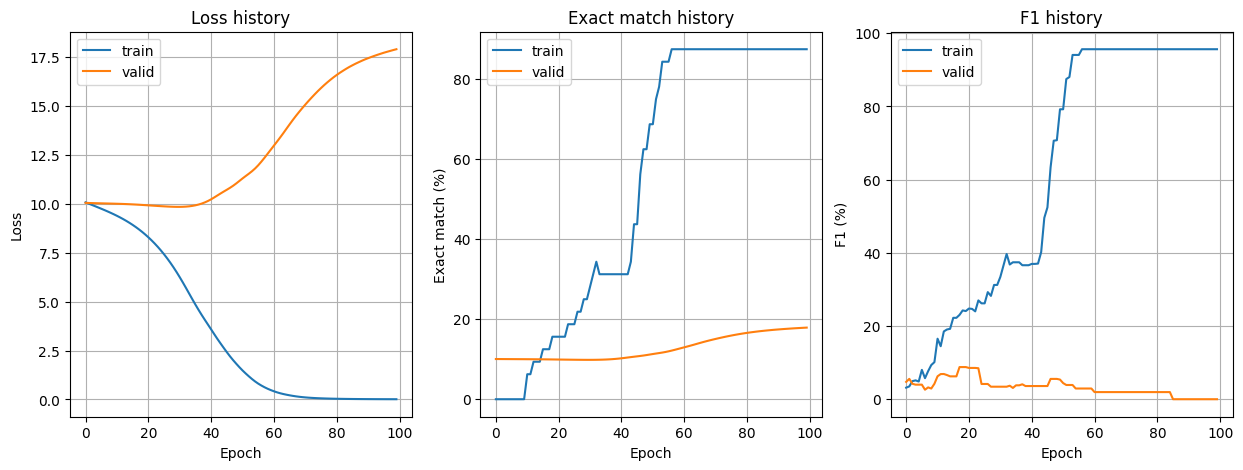

In [226]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['valid_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['em'], label='train')
axes[1].plot(history['valid_em'], label='valid')
axes[1].set_title('Exact match history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Exact match (%)')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['f1'], label='train')
axes[2].plot(history['valid_f1'], label='valid')
axes[2].set_title('F1 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

***Inference***

In [113]:
# model.load_state_dict(torch.load("./checkpoints/drqa.pth"))
# model.to(DEVICE)

In [123]:
def inference(model: nn.Module, context: spacy.tokens.doc.Doc, question: spacy.tokens.doc.Doc,
              text_vocab: Vocabulary, pos_vocab: Vocabulary, ner_vocab: Vocabulary, device: torch.device):
    # Build extra features
    question = [token.text.lower() for token in question]
    counts = collections.Counter(map(lambda token: token.text.lower(), context))
    freqs = {index: counts[token.text.lower()] for index, token in enumerate(context)}
    freqs_norm = sum(freqs.values())
    em, pos, ner, ntf = zip(
        *map(lambda index: [
            context[index].text.lower() in question, context[index].tag_,
            context[index].ent_type_ or 'None',
            freqs[index] / freqs_norm
        ], range(len(context)))
    )

    # Build tensors
    batch = DrQATensorDatasetBatch(
        id_=None,
        context=(
            torch.LongTensor([*map(lambda word: text_vocab.stoi(word), context)]).unsqueeze(0).to(device),
            torch.LongTensor([len(context)])
        ), question=(
            torch.LongTensor([*map(lambda word: text_vocab.stoi(word), question)]).unsqueeze(0).to(device),
            torch.LongTensor([len(question)])
        ), target=None,
        exact_match=torch.LongTensor(em).unsqueeze(0).to(device),
        part_of_speech=torch.LongTensor([*map(lambda x: pos_vocab.stoi(x), pos)]).unsqueeze(0).to(device),
        named_entity_type=torch.LongTensor([*map(lambda x: ner_vocab.stoi(x), ner)]).unsqueeze(0).to(device),
        normalized_term_frequency=torch.LongTensor(ntf).unsqueeze(0).to(device)
    )

    # Prediction
    model.eval()
    with torch.no_grad():
        # Feed the model
        start, end = model(batch)
    
        # Decode the result indexes
        start_index, end_index, proba = model.decode(starts=F.softmax(start, dim=-1), ends=F.softmax(end, dim=-1))
        print(start_index, end_index)

        # Extract the answer
        answer = context[start_index[0]:end_index[0] + 1]

    return answer, proba[0]

In [126]:
for index in np.random.choice(len(valid_qas), size=25, replace=False):
    id = valid_qas[index].id_
    context = valid_qas[index].context
    question = valid_qas[index].question

    answers = []
    for qa in valid_qas:
        if id == qa.id_:
            answers.append(qa.answer)

    prediction, proba = inference(
        model=model,
        context=context,
        question=question,
        text_vocab=text_vocabulary,
        pos_vocab=part_of_speech_vocabulary,
        ner_vocab=named_entity_types_vocabulary,
        device=DEVICE
    )
    
    html = f'<p><span><b>Context:</b> {context.text}</span><br />'
    html += f'<span><b>Question:</b> {question.text}</span><br />'
    html += f'<span style="color:blue"><b>Possible answers:</b><br /><ul>'
    for answer in answers:
        html += f'<li style="color:blue">{answer.text}</li>'
    html += '</ul></span><br />'
    html += f'<span style="color:green"><b>Prediction:</b>={prediction}=</span><br />'
    html += f'<span style="color:green"><b>Probability:</b> {proba * 100:.3f}%</span><br />'
    display(HTML(html))
    print('='*100)

[21] [37]


[32] [74]


[1] [126]


[22] [115]


[2] [102]


[45] [106]


[31] [66]


[1] [2]


[2] [2]


[35] [28]


[32] [143]


[38] [119]


[11] [52]


[5] [135]


[38] [43]


[16] [113]


[4] [128]


[116] [131]


[261] [261]


[15] [15]


[37] [28]


[120] [124]


[87] [103]


[81] [94]


[95] [101]
